In [ ]:
import huggingface_hub

In [ ]:
from google.colab import userdata
token = userdata.get('HF_TOKEN')

In [ ]:
from huggingface_hub import login
login(token)
print('Successful login')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successful login


## Ready training data


{"paragraph" : "data...."} in jsonl files
max_length restricted to 256 characters to avoid out of memory errors

In [ ]:
!unzip selected_data_txt.zip

Archive:  selected_data_txt.zip
   creating: selected_data_txt/
  inflating: selected_data_txt/ADMINISTRATIVE_LAW_FF.txt  
  inflating: selected_data_txt/ADVOCATES_ACT_f.txt  
  inflating: selected_data_txt/ANCIENT_LAW _F.txt  
  inflating: selected_data_txt/ARBITRATION_And_CONCILIATION.txt  
  inflating: selected_data_txt/CIVIL_PROCEDURE_CODE_FINAL2012.txt  
  inflating: selected_data_txt/COMPANY_LAW.txt  
  inflating: selected_data_txt/CONSTITUTION_OF_INDIA.txt  
  inflating: selected_data_txt/CONTRACT-Specific_ReliefAct.txt  
  inflating: selected_data_txt/CONTRACT_Act_F.txt  
  inflating: selected_data_txt/CRIMINAL_PROCEDURE_CODE.txt  
 extracting: selected_data_txt/EVIDENCE_ACT.txt  
  inflating: selected_data_txt/HINDU_LAW_2012.txt  
  inflating: selected_data_txt/INDEMNITY_GUARANTEE_BAILMENT.txt  
  inflating: selected_data_txt/INDIAN_CONSTITUTIONAL_HISTORY.txt  
  inflating: selected_data_txt/INDIAN_LEGAL_HISTORY.txt  
  inflating: selected_data_txt/INDIAN_PENAL_CODE.txt  
  in

In [ ]:
import os
import json

# Paths to the folder and output files
input_folder = "selected_data_txt"
train_output_file = "data.jsonl"
eval_output_file = "data_validation.jsonl"

# Function to process each note into 256-character paragraphs
def process_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read().strip().replace('\n', ' ')
        paragraphs = []
        while len(content) > 0:
            paragraphs.append({"paragraph": content[:256]})
            content = content[256:].strip()
        return paragraphs

# Split data into training and evaluation sets (e.g., 80% training, 20% evaluation)
def split_data(data, train_ratio=0.8):
    split_point = int(len(data) * train_ratio)
    return data[:split_point], data[split_point:]

# Process all .txt files in the folder
all_paragraphs = []
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_folder, filename)
        all_paragraphs.extend(process_file(file_path))

# Split the data into training and evaluation datasets
train_data, eval_data = split_data(all_paragraphs)

# Write train and eval datasets to their respective jsonl files
with open(train_output_file, 'w', encoding='utf-8') as train_file:
    for entry in train_data:
        json.dump(entry, train_file)
        train_file.write('\n')

with open(eval_output_file, 'w', encoding='utf-8') as eval_file:
    for entry in eval_data:
        json.dump(entry, eval_file)
        eval_file.write('\n')

print(f"Processed {len(train_data)} training paragraphs and {len(eval_data)} evaluation paragraphs.")


Processed 13038 training paragraphs and 3260 evaluation paragraphs.


## Load the model and train

Mistral 7b instruct v0.1 base model used

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='data.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='data_validation.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def formatting_func(example):
    text = f"### The following is a note in a Law Textbook: {example['paragraph']}"
    return text

### Load Base model

In [ ]:
!pip install -q -U bitsandbytes
!pip install accelerate
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 6.4 MB/s eta 0:00:00


In [ ]:
import bitsandbytes as bnb
import accelerate
print(bnb.__version__)
print(accelerate.__version__)


0.43.3
0.34.2


In [ ]:
pip install -U transformers


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import bitsandbytes as bnb
from peft import LoraConfig, get_peft_model

base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype = torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
)

model.gradient_checkpointing_enable()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Tokenization

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/13038 [00:00<?, ? examples/s]

Map:   0%|          | 0/3260 [00:00<?, ? examples/s]

16298


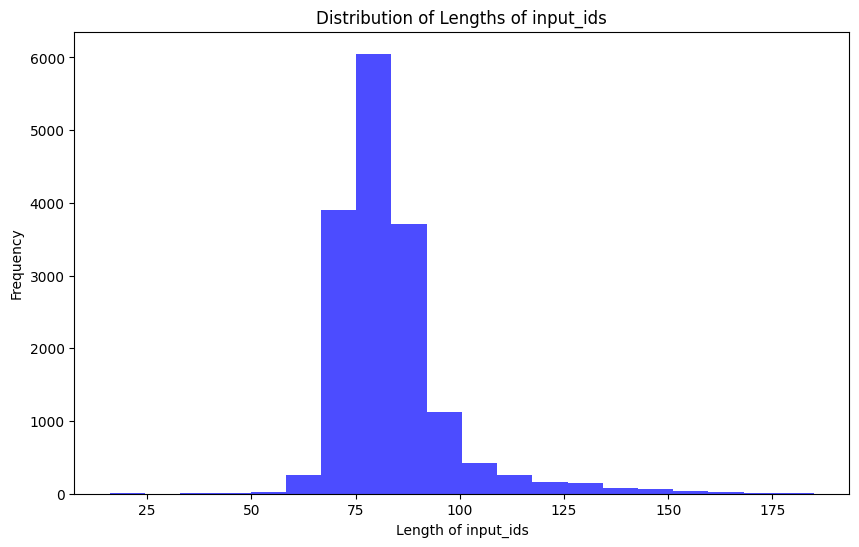

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 128 # This was an appropriate max length for our dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/13038 [00:00<?, ? examples/s]

Map:   0%|          | 0/3260 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 415, 2296, 349, 264, 5039, 297, 264, 5802, 7379, 3521, 28747, 290, 2508, 582, 28705, 298, 3608, 28731, 756, 4192, 28738, 2431, 28735, 259, 14381, 1532, 260, 9328, 2287, 28740, 28723, 10822, 402, 1002, 3782, 28747, 2287, 28740, 23628, 259, 28770, 2287, 28750, 10757, 4595, 259, 28770, 259, 28770, 28705, 3011, 7457, 302, 5558, 259, 28781, 259, 28781, 3885, 3011, 7457, 259, 28784, 259, 28782, 28705, 1618, 1438, 466, 359, 359, 359, 359, 2600, 2]


16298


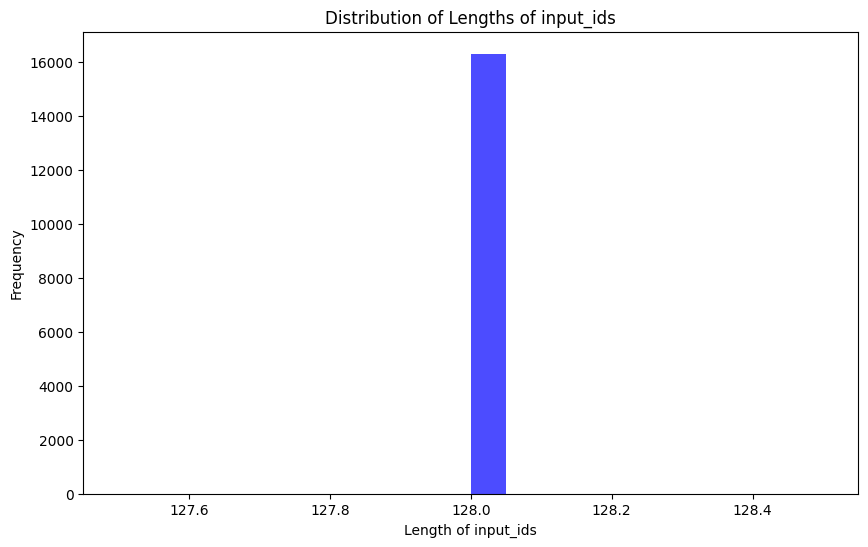

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)
# check is all of max_len

## Set up LoRA

In [ ]:
from peft import get_peft_model
# Configure LoRA
lora_config = LoraConfig(
    r=32,  # Rank of the adapter
    lora_alpha=64,  # Scaling factor
    target_modules=["q_proj", "v_proj", "o_proj", "k_proj", "gate_proj"],  # LoRA applied to these modules
    lora_dropout=0.05,  # Dropout probability
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

## Training

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./mistral-law-output",  # Directory to save the model and checkpoints
    per_device_train_batch_size=2,  # Batch size per device during training
    per_device_eval_batch_size=2,   # Batch size per device during evaluation
    gradient_accumulation_steps=8,  # Accumulate gradients over 8 steps
    gradient_checkpointing=True,    # Save memory by not storing intermediate activations
    max_steps=400,                 # Total number of training steps to run
    learning_rate=2e-5,             # Learning rate for optimization
    bf16=True,                      # Use float16 precision
    optim="paged_adamw_8bit",       # 8-bit AdamW optimizer
    warmup_steps=2,
    logging_steps=100,               # Frequency of logging training metrics
    logging_dir="./logs",           # Directory to store logs
    save_strategy="steps",          # Save the model checkpoint every `save_steps`
    save_steps=100,                 # Save checkpoints every 25 steps
    eval_strategy="steps",    # Evaluate the model every `eval_steps`
    eval_steps=100,                 # Evaluate and save checkpoints every 25 steps
    do_eval=True,                   # Perform evaluation at the end of training
    hub_model_id="rujool/mistral7blaw-3",
    push_to_hub=True,
)

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
import torch

# Explicitly set the `use_reentrant` parameter in PyTorch
torch.utils.checkpoint.use_reentrant = False



In [ ]:
model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
